In [210]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [211]:
import numpy as np
import matplotlib.pyplot as plt

In [212]:
def ppfft(f):
    #f is assumed N x N where N is even. If not, we just force it to be
    [h, w] = f.shape
    N = h
    f2 = f
    if h != w or np.mod(h, 2) == 1:
        N = int(np.ceil(max(h, w) / 2) * 2) #N is biggest dimension, but force even
        f2 = np.zeros([N, N])
        f2[N // 2 - int(h / 2):N // 2 - int(h / 2) + h, N // 2 - int(w / 2):N // 2 - int(w / 2) + w] = f
    ppff = np.zeros([2 * N, 2 * N]) * 1j

    #Constructing Quadrants 1 and 3
    ff = np.fft.fft(f2, N * 2, axis=0)
    ff = np.fft.fftshift(ff, 0)
    for i in range(-N, N):
        ppff[i + N, N - 1::-1] = fracfft(ff[i + N, :], i / (N ** 2), 1)

    #Constructing quadrants 2 and 4
    ff = np.fft.fft(f2, N * 2, axis=1)
    ff = np.fft.fftshift(ff, 1)
    ff = ff.T

    for i in range(-N, N):
        x = np.arange(0, N)
        factor = np.exp(1j * 2 * np.pi * x * (N / 2 - 1) * i / (N ** 2))
        ppff[i + N, N:2 * N] = fracfft(ff[i + N, :] * factor, i / (N ** 2))
    return ppff

In [213]:
def fracfft(f, alpha, centered=0):
    f = np.reshape(f.T, f.size)#flatten f
    N = len(f)#get length

    if centered == 1:
        x = np.arange(0, N)
        factor = np.exp(1j * np.pi * x * N * alpha)
        f = f * factor

    x = np.append(np.arange(0, N), np.arange(-N, 0))
    factor = np.exp(-1j * np.pi * alpha * x ** 2)
    ff = np.append(f, np.zeros(N))
    ff = ff * factor
    XX = np.fft.fft(ff)
    YY = np.fft.fft(np.conj(factor))

    result = np.fft.ifft(XX * YY)
    result = result * factor
    result = result[0:N]
    return result

In [214]:
import cv2

In [215]:
image = cv2.imread("/content/drive/MyDrive/signalfile/image.jpg")

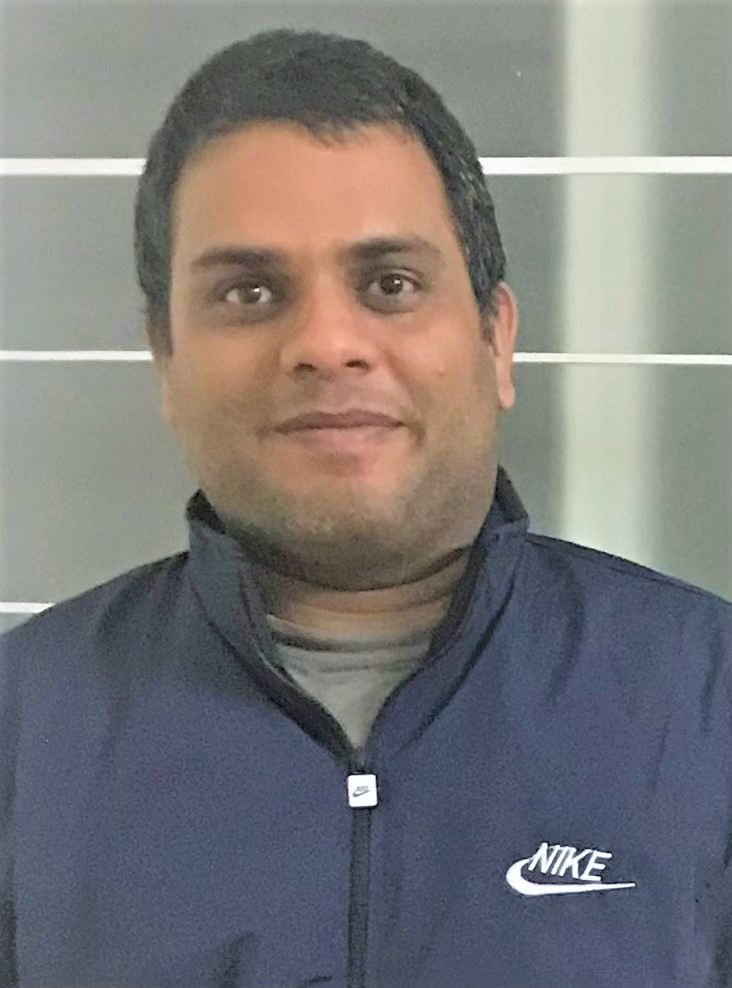

In [216]:
from google.colab.patches import cv2_imshow
cv2_imshow(image)

In [217]:
f=image
f = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)
[h, w] = f.shape
print(h)
print(w)

988
732


In [218]:
ppff=ppfft(f)

In [219]:
meanppff = np.fft.fftshift(np.mean(np.abs(ppff), axis=1))

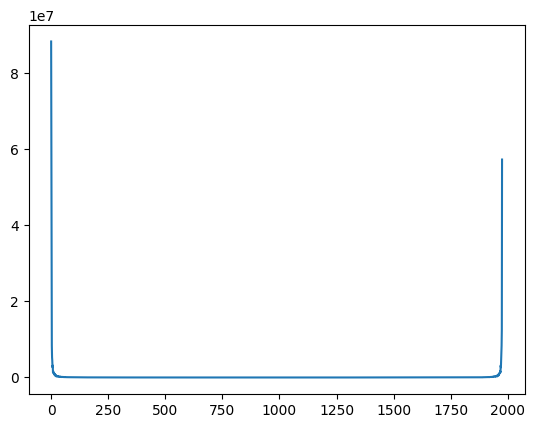

In [220]:
plt.plot(meanppff)

In [221]:
points=[10, 15, 20, 25, 30, 35, 40, 45, 50]

In [222]:
num = np.asarray(points) * np.pi
points = num / np.round(len(meanppff) / 2)

W = f.shape[1]
H = f.shape[0]
points

array([0.0317975 , 0.04769624, 0.06359499, 0.07949374, 0.09539249,
       0.11129124, 0.12718999, 0.14308873, 0.15898748])

In [223]:
def ewt_beta(x):
    bm = (x >= 0) * (x <= 1) \
        * (x ** 4 * (35 - 84 * x + 70 * x ** 2 - 20 *x **3))
    bm += (x > 1)
    return bm

In [224]:
def ewt2d_LPscaling(radii, bound0, gamma):
    an = 1 / (2 * gamma * bound0)
    mbn = (1 - gamma) * bound0 # inner circle up to beginning of transtion
    pbn = (1 + gamma) * bound0 #end of transition

    scaling = 0 * radii #initiate w/ zeros
    scaling[radii < mbn] = 1
    scaling[radii >= mbn] = np.cos(np.pi * ewt_beta(an * (radii[radii >= mbn] - mbn)) / 2)
    scaling[radii > pbn] = 0
    return scaling

In [225]:
def ewt2d_LPwavelet(radii, bound1, bound2, gamma):
    wan = 1 / (2 * gamma * bound1) #scaling factor
    wam = 1 / (2 * gamma * bound2)
    wmbn = (1 - gamma) * bound1 #beginning of lower transition
    wpbn = (1 + gamma) * bound1 #end of lower transition
    wmbm = (1 - gamma) * bound2  #beginning of upper transition
    wpbm = (1 + gamma) * bound2 #end of upper transition

    wavelet = 0 * radii #initialize w/ zeros
    inside = (radii > wmbn) * (radii < wpbm)
    wavelet[inside] = 1.0 #set entire angular wedge equal to 1
    temp = inside*(radii >= wmbm) * (radii <= wpbm) #upper transition
    wavelet[temp] *= np.cos(np.pi * ewt_beta(wam * (radii[temp] - wmbm)) / 2)
    temp = inside * (radii >= wmbn) * (radii <= wpbn) #lower transition
    wavelet[temp] *= np.sin(np.pi * ewt_beta(wan * (radii[temp] - wmbn)) / 2)
    return wavelet

In [226]:
def ewt2d_LPFilterbank(bounds_scales, h, w):
    if h % 2 == 0:
        h += 1
        h_extended = 1
    else:
        h_extended = 0
    if w % 2 == 0:
        w += 1
        w_extended = 1
    else:
        w_extended = 0
    #First, we calculate gamma for scales
    gamma_scales = np.pi
    for k in range(0, len(bounds_scales) - 1):
        r = (bounds_scales[k + 1] - bounds_scales[k]) / (bounds_scales[k + 1] + bounds_scales[k])
        if r < gamma_scales and r > 1e-16:
            gamma_scales = r
    r = (np.pi - bounds_scales[-1]) / (np.pi + bounds_scales[-1]) #check last bound
    if r < gamma_scales and r > 1e-16:
        gamma_scales = r

    if gamma_scales > bounds_scales[0]:     #check first bound
        gamma_scales = bounds_scales[0]
    gamma_scales *= (1 - 1 / max(h, w)) #guarantees that we have strict inequality
    radii = np.zeros([h, w])

    h_center = h // 2 + 1
    w_center = w // 2 + 1
    for i in range(0, h):
        for j in range(0, w):
            ri = (i + 1.0 - h_center) * np.pi / h_center
            rj = (j + 1.0 - w_center) * np.pi / w_center
            radii[i, j] = np.sqrt(ri ** 2 + rj ** 2)

    mfb = []
    mfb.append(ewt2d_LPscaling(radii, bounds_scales[0], gamma_scales))
    for i in range(0, len(bounds_scales) - 1):
        mfb.append(ewt2d_LPwavelet(radii, bounds_scales[i], bounds_scales[i + 1], gamma_scales))
    mfb.append(ewt2d_LPwavelet(radii, bounds_scales[-1], 2 * np.pi, gamma_scales))

    if h_extended == 1: #if we extended the height of the image, trim
        h -= 1
        for i in range(0, len(mfb)):
            mfb[i] = mfb[i][0:-1, :]
    if w_extended == 1: #if we extended the width of the image, trim
        w -= 1
        for i in range(0, len(mfb)):
            mfb[i] = mfb[i][:, 0:-1]
    #invert the fftshift since filters are centered
    for i in range(0, len(mfb)):
        mfb[i] = np.fft.ifftshift(mfb[i])

    #Resymmetrize for even images
    if h_extended == 1:
        s = np.zeros(w)
        if w % 2 == 0:
            mfb[-1][h // 2, 1:w // 2] += mfb[-1][h // 2, -1:w // 2:-1]
            mfb[-1][h // 2, w // 2 + 1:] = mfb[-1][h // 2, w // 2 - 1:0:-1]
            s += mfb[-1][h // 2, :] ** 2
            #normalize for tight frame
            mfb[-1][h // 2, 1:w // 2] /= np.sqrt(s[1:w // 2])
            mfb[-1][h // 2, w // 2 + 1:] /= np.sqrt(s[w // 2 + 1:])
        else:
            mfb[-1][h // 2, 0:w // 2] += mfb[-1][h // 2, -1:w // 2:-1]
            mfb[-1][h // 2, w // 2 + 1:] = mfb[-1][h // 2, w // 2-1::-1]
            s += mfb[-1][h // 2, :] ** 2
            #normalize for tight frame
            mfb[-1][h // 2, 0:w // 2]  /= np.sqrt(s[0:w // 2])
            mfb[-1][h // 2, w // 2 + 1:] /= np.sqrt(s[w // 2 + 1:])
    if w_extended == 1:
        s = np.zeros(h)
        if h%2 == 0:
            mfb[-1][1:h // 2, w // 2] += mfb[-1][-1:h // 2:-1, w // 2]
            mfb[-1][h // 2 + 1:, w // 2] = mfb[-1][h // 2 - 1:0:-1, w // 2]
            s += mfb[-1][:, w // 2] ** 2
            #normalize for tight frame
            mfb[-1][1:h // 2, w // 2] /= np.sqrt(s[1:h // 2])
            mfb[-1][h // 2 + 1:, w // 2] /= np.sqrt(s[h // 2 + 1:])
        else:
            mfb[-1][0 : h // 2, w // 2] += mfb[-1][-1:h // 2:-1, w // 2]
            mfb[-1][h // 2 + 1:, w // 2] = mfb[-1][h // 2 - 1::-1, w // 2]
            s += mfb[-1][:, w // 2] ** 2
            #normalize for tight frame
            mfb[-1][0:h // 2, w // 2] /= s[0:h // 2]
            mfb[-1][h // 2 + 1:, w // 2] /= s[h // 2 + 1:]
    return mfb

In [227]:
mfb = ewt2d_LPFilterbank(points, H, W)
#filter out coefficients
ff = np.fft.fft2(f)
ewtLP = [None] * len(mfb)
for k in range(len(mfb)):
    ewtLP[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ff))


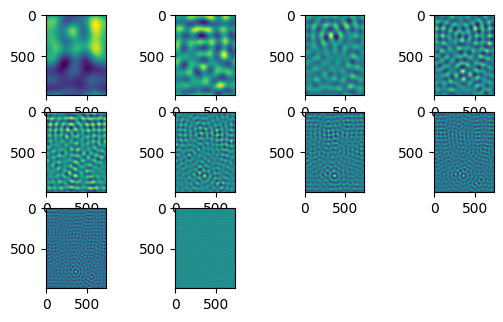

In [228]:
plt.figure()
for m in range(len(mfb)):
    plt.subplot(4, 4, m+1)
    xx = ewtLP[m]
    plt.imshow(xx)